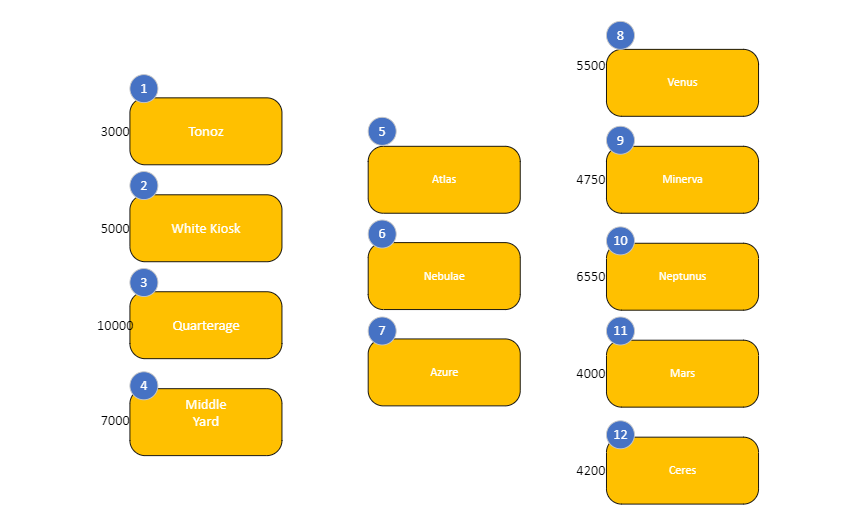

In [85]:
from pulp import *
import pandas as pd
import numpy as np
from pulp import lpSum

In [86]:

# Set the seed number as your student ID (ignore letters and use only numbers)
np.random.seed(19061047)

# Shipment cost from factory to distribution center
RandomFtoD1 = np.round(np.random.uniform(low=1, high=10, size=12), 0).astype(int)
RandomFtoD2 = np.reshape(RandomFtoD1, (4, 3))
CostFtoD = pd.DataFrame(RandomFtoD2, columns=['Atlas', 'Nebule', 'Azure'],
                         index=['Tonoz', 'White Kiosk', 'Quarterage', 'Middle Yard'])
# CostFtoD gives the shipment cost from factory to distribution center

# Shipment cost from distribution center to store
RandomDtoS1 = np.round(np.random.uniform(low=1, high=10, size=15), 0).astype(int)
RandomDtoS2 = np.reshape(RandomDtoS1, (3, 5))
CostDtos = pd.DataFrame(RandomDtoS2, columns=["Venus", "Minerva", "Neptunus", "Mars", "Ceres"],
                         index=['Atlas', 'Nebule', 'Azure'])
# CostDtos gives the shipment cost from distribution center to store

# Shipment cost from factory to store
RandomFtos1 = np.round(np.random.uniform(low=1, high=10, size=20), 0).astype(int)
RandomFtos2 = np.reshape(RandomFtos1, (4, 5))
CostFtos = pd.DataFrame(RandomFtos2, columns=["Venus", "Minerva", "Neptunus", "Mars", "Ceres"],
                         index=["Tonoz", "White Kiosk", "Quarterage", "Middle Yard"])
# CostFtos gives the shipment cost from factory to store

# Your Required Information About Shipment Cost
print("The shipment cost from factory to distribution center")
print(CostFtoD)
print("\nThe shipment cost from distribution center to store")
print(CostDtos)
print("\nThe shipment cost from factory to store")
print(CostFtos)


The shipment cost from factory to distribution center
             Atlas  Nebule  Azure
Tonoz           10       2      8
White Kiosk     10       9      7
Quarterage       7       9      2
Middle Yard      8       9      1

The shipment cost from distribution center to store
        Venus  Minerva  Neptunus  Mars  Ceres
Atlas       2        8        10     4      9
Nebule     10        2         6     6      2
Azure       7        3        10     6      9

The shipment cost from factory to store
             Venus  Minerva  Neptunus  Mars  Ceres
Tonoz            1        2         9     6      2
White Kiosk      9        2         2     4      3
Quarterage       8        9         3     2      3
Middle Yard      9        9         1     3      3


In [87]:
"""
print("\nThe shipment cost from distribution center to store")
CostDtos["Minerva"].Azure = 5
CostDtos
"""

'\nprint("\nThe shipment cost from distribution center to store")\nCostDtos["Minerva"].Azure = 5\nCostDtos\n'

In [88]:
 # Creates a list of all the supply nodes
factories = ["Tonoz", "WhiteKiosk", "Quarterage", "MiddleYard"]

# Creates a dictionary for the number of units of supply for each supply node
supply = {"Tonoz": 3000, "WhiteKiosk": 5000, "Quarterage":10000,"MiddleYard":7000 }

# Creates a list of all demand nodes
stores = ["Venus", "Minerva", "Neptunus","Mars","Ceres"]

# Creates a dictionary for the number of units of demand for each demand node
demand = {
    "Venus": 5500,
    "Minerva": 4750 ,
    "Neptunus": 6550,
    "Mars": 4000,
    "Ceres":4200
}

# Intermediate nodes
dist_centers=["Atlas","Nebulae","Azure"]

# Creates a list of costs of each transportation path

costs_1 = CostFtoD.values.tolist() # f_to_dc

costs_2 = CostDtos.values.tolist() # dc_to_s

costs_3 = CostFtos.values.tolist() # f_to_s


# The cost data is made into a dictionary
costs_1 = makeDict([factories, dist_centers], costs_1, 0)

# The cost data is made into a dictionary
costs_2 = makeDict([dist_centers, stores], costs_2, 0)

costs_3 = makeDict([factories, stores], costs_3, 0)

prob = LpProblem("MaterialSupplyProblem", LpMinimize)

In [89]:
routes = []

# Factories to Distribution Centers
routes += [(f, dc) for f in factories for dc in dist_centers]

# Factories to Stores
routes += [(f, s) for f in factories for s in stores]

# Distribution Centers to Stores
routes += [(dc, s) for dc in dist_centers for s in stores]



In [90]:
Vars = {}

# Iterate over the routes and create the corresponding decision variables
for route in routes:
    var_name = f"Route_{route[0]}_{route[1]}"  # Variable name based on the route
    var = LpVariable(var_name, lowBound=0, cat="Integer")  # Create the decision variable
    Vars[route] = var  # Add the variable to the dictionary

In [91]:
# Initialize the objective function expression
obj_func = lpSum(Vars[route] * costs_1[route[0]][route[1]] + Vars[route] * costs_2[route[0]][route[1]] + Vars[route] * costs_3[route[0]][route[1]] for route in routes)

# Set the objective function in the 'prob' problem
prob += obj_func


In [92]:
# Iterate over the supply nodes (factories)
for factory in factories:
    # Get the decision variables associated with the factory
    factory_vars = [Vars[route] for route in routes if route[0] == factory]
    
    # Get the supply capacity for the factory
    factory_supply = supply[factory]
    
    # Create and add the supply maximum constraint for the factory
    supply_constraint = LpConstraint(
        e=lpSum(factory_vars),
        sense=LpConstraintEQ,
        rhs=factory_supply,
        name=f"Supply_{factory}_Constraint"
    )
    prob.addConstraint(supply_constraint)

In [93]:
# Iterate over the demand nodes (stores)
for store in stores:
    # Get the decision variables associated with the store
    store_vars = [Vars[route] for route in routes if route[1] == store]
    
    # Get the demand quantity for the store
    store_demand = demand[store]
    
    # Create and add the demand minimum constraint for the store
    demand_constraint = LpConstraint(
        e=lpSum(store_vars),
        sense=LpConstraintEQ, # LpConstraintEQ-->"=" , LpConstraintLE --> "<=" 
        rhs=store_demand,
        name=f"Demand_{store}_Constraint"
    )
    prob.addConstraint(demand_constraint)

In [94]:
# Iterate over the intermediate nodes (dist_centers) as transshipment nodes
for transshipment_node in dist_centers:
    # Get the decision variables associated with the transshipment node as incoming and outgoing routes
    incoming_vars = [Vars[route] for route in routes if route[1] == transshipment_node]
    outgoing_vars = [Vars[route] for route in routes if route[0] == transshipment_node]
    
    # Create and add the transshipment constraint for the transshipment node
    transshipment_constraint = LpConstraint(
        e=lpSum(incoming_vars) - lpSum(outgoing_vars),
        sense=LpConstraintEQ,
        rhs=0,
        name=f"Transshipment_{transshipment_node}_Constraint"
    )
    prob.addConstraint(transshipment_constraint)

In [95]:
# The problem data is written to an .lp file
prob.writeLP("TransshipmentProblem.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# Print the variables optimized value
for v in prob.variables():
    print(v.name, "=", v.varValue)
# The optimised objective function value is printed to the screen
print("Value of Objective Function = ", value(prob.objective))

Route_Atlas_Ceres = 0.0
Route_Atlas_Mars = 0.0
Route_Atlas_Minerva = 0.0
Route_Atlas_Neptunus = 0.0
Route_Atlas_Venus = 0.0
Route_Azure_Ceres = 0.0
Route_Azure_Mars = 0.0
Route_Azure_Minerva = 0.0
Route_Azure_Neptunus = 0.0
Route_Azure_Venus = 0.0
Route_MiddleYard_Atlas = 0.0
Route_MiddleYard_Azure = 0.0
Route_MiddleYard_Ceres = 450.0
Route_MiddleYard_Mars = 0.0
Route_MiddleYard_Minerva = 0.0
Route_MiddleYard_Nebulae = 0.0
Route_MiddleYard_Neptunus = 6550.0
Route_MiddleYard_Venus = 0.0
Route_Nebulae_Ceres = 0.0
Route_Nebulae_Mars = 0.0
Route_Nebulae_Minerva = 0.0
Route_Nebulae_Neptunus = 0.0
Route_Nebulae_Venus = 0.0
Route_Quarterage_Atlas = 0.0
Route_Quarterage_Azure = 0.0
Route_Quarterage_Ceres = 3500.0
Route_Quarterage_Mars = 4000.0
Route_Quarterage_Minerva = 0.0
Route_Quarterage_Nebulae = 0.0
Route_Quarterage_Neptunus = 0.0
Route_Quarterage_Venus = 2500.0
Route_Tonoz_Atlas = 0.0
Route_Tonoz_Azure = 0.0
Route_Tonoz_Ceres = 0.0
Route_Tonoz_Mars = 0.0
Route_Tonoz_Minerva = 0.0
Route_T